# Generating question answer pairs from text

In [1]:
import importlib
import os

from tensorflow.keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Lambda
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from tensorflow.keras.utils import plot_model

import numpy as np
import random
import pickle as pkl

from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, get_glove

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

# data

In [3]:

training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()


In [4]:
t = next(training_data_gen)

In [5]:
idx = 0

print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])

document_tokens
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


question_input_tokens
 [2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]


answer_masks
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


answer_labels
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [6]:
# GloVe

glove = get_glove()

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GRU_UNITS = 100


GLOVE
VOCAB_SIZE:  9984
EMBEDDING_DIMENS:  100


# parameters

In [7]:
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

# architecture

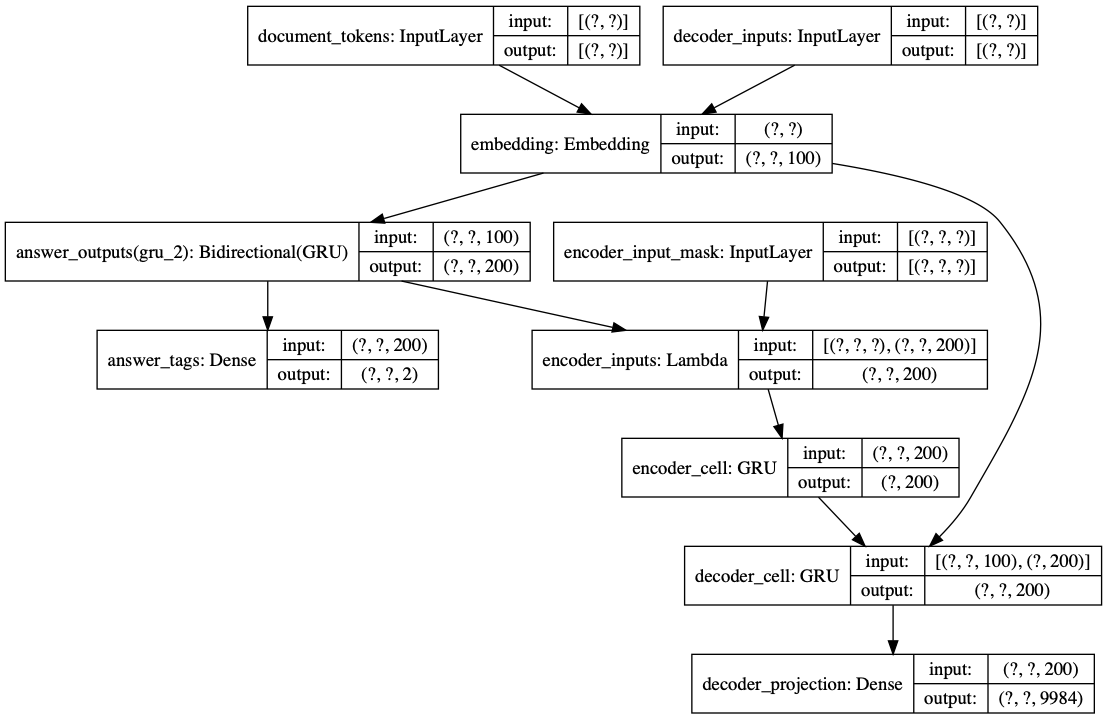

In [18]:
document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file=os.path.join(RUN_FOLDER ,'viz/model.png'),show_shapes=True)

In [9]:
decoder_emb.shape

TensorShape([None, None, 100])

In [10]:
answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])

In [11]:
total_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_tokens (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    998400      document_tokens[0][0]            
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
answer_outputs (Bidirectional)  (None, None, 200)    121200      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_input_mask (InputLayer) [(None, None, None)] 0                                        

In [12]:
#### INFERENCE MODEL ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])



In [13]:
#### COMPILE TRAINING MODEL ####

opti = Adam(lr=0.001)
total_model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy']
                    , optimizer=opti
                    , loss_weights = [1,1]) 


# train

In [14]:
training_loss_history = []
test_loss_history = []

EPOCHS = 2000
start_epoch = 1

In [15]:
for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("Epoch {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
            
        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']]
            , [np.expand_dims(batch['answer_labels'], axis = -1), np.expand_dims(batch['question_output_tokens'], axis = -1)]
        )
        
        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']]
            , [np.expand_dims(val_batch['answer_labels'], axis = -1), np.expand_dims(val_batch['question_output_tokens'], axis = -1)]
        )
        
        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)
        
        print("{}: Train Loss: {} | Test Loss: {}".format(i, training_loss, test_loss))
        
        total_model.save_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(epoch)))
        

Epoch 1
0: Train Loss: [5.358553, 0.54447705, 4.814076] | Test Loss: [9.527245, 0.37646043, 9.1507845]
1: Train Loss: [5.5388675, 0.36127976, 5.1775875] | Test Loss: [9.390775, 0.29728138, 9.093493]
2: Train Loss: [5.2074175, 0.43401504, 4.7734027] | Test Loss: [9.312523, 0.2819618, 9.030561]
3: Train Loss: [5.5489464, 0.35577145, 5.193175] | Test Loss: [9.23679, 0.28210592, 8.954684]
4: Train Loss: [5.0804615, 0.5494464, 4.531015] | Test Loss: [9.144372, 0.28190714, 8.862465]
5: Train Loss: [5.186718, 0.33600417, 4.8507137] | Test Loss: [9.021345, 0.28114313, 8.740202]
6: Train Loss: [4.6811576, 0.33942044, 4.3417373] | Test Loss: [8.869452, 0.2807353, 8.588717]
7: Train Loss: [4.819796, 0.41325742, 4.4065385] | Test Loss: [8.682507, 0.2813026, 8.401204]
8: Train Loss: [4.5515738, 0.49589273, 4.055681] | Test Loss: [8.466556, 0.2862665, 8.180289]


KeyboardInterrupt: 

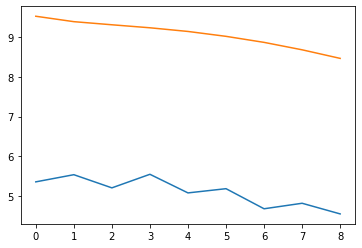

In [16]:
#### SHOW LOSSES ####

plt.plot(np.array(training_loss_history)[:,0])
plt.plot(np.array(test_loss_history)[:,0])
plt.show()
        
pkl.dump([training_loss_history, test_loss_history], open(os.path.join(RUN_FOLDER, 'weights/histories.pkl'), 'wb'))